# Adding to previous Titanic Analysis

- Boolean expansion of the categorical variables (get_dummies)
- Train test split with X_train, X_test, y_train, y_test (instead of the test, train = )
- Cleaning up NaN values (Imputer)
- Fitting a model (LogisticRegression, KNeighborsClassifier)

In [18]:
# initial imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

%matplotlib inline

## **[1] data import**

In [4]:
titanic = pd.read_excel('titanic3.xls')

## **[2] Tiny bit of data exploration**

In [6]:
titanic.shape

(1309, 14)

In [7]:
titanic.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [3]:
titanic.keys()

Index(['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest'],
      dtype='object')

In [4]:
titanic.describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


In [11]:
# want to explore what it would look like to use cabin as a categorical variable

titanic.groupby('cabin')['fare'].mean().sort_values(ascending = False)

#looks like there are too many types for it to be a meaningful predictor...
# also, strange that a few cabins have a mean of 0 for the fare paid

cabin
B101               512.329200
B51 B53 B55        343.219467
C23 C25 C27        263.000000
B57 B59 B63 B66    262.375000
B61                262.375000
B58 B60            247.520800
C62 C64            227.525000
C45                227.525000
C55 C57            221.779200
C97                221.779200
C95                221.779200
C132               211.500000
C80                211.500000
C130               211.500000
C82                211.500000
B3                 211.337500
B5                 211.337500
C7                 164.866700
C91                153.462500
C125               153.462500
C22 C26            151.550000
B80                146.520800
B78                146.520800
C89                136.779200
C99                135.633300
C32                135.633300
E34                134.500000
E40                134.500000
E39 E41            134.500000
B96 B98            120.000000
                      ...    
E38                 26.550000
C87                 26.550000
E25 

In [18]:
# looking into fares that are 0 more closely

zero_fare = titanic[titanic.fare < 1]

print(len(zero_fare) / titanic.shape[0])

# it's only 1% of my data, so I'm not going to worry about it

0.012987012987012988


getting a sense of missing values

In [22]:
missing_data_ratio = np.logical_not(titanic.isnull()).sum() / titanic.shape[0]

missing_data_ratio.sort_values(ascending = True)

body         0.092437
cabin        0.225363
boat         0.371276
home.dest    0.569137
age          0.799083
embarked     0.998472
fare         0.999236
pclass       1.000000
survived     1.000000
name         1.000000
sex          1.000000
sibsp        1.000000
parch        1.000000
ticket       1.000000
dtype: float64

** Feature Observations / guesses ** 

possible good predictors:
- "boat" (access to one / assignment of one), but it's going to be problematic since we have values for only 37% of the data, so I'm going to exclude it
- "age" since presumably children would be priority, but we are missing about 20%. Probably still useful, but muight have to fill it with the median age for missing values and see if the model performs better that way
- "sex" as women survived more than men
- "pclass" since maybe the more wealthy people were in a better position to leave the boat

probably irrelevant:
- "ticket" is irrelevant since it's just a number (like a barcode)
- "home.dest" seems irrelevant, since they were all on the boat regardless of where they were going
- "embarked" also seems irrelevant, but we can throw it in the mix and see what happens

others:
- "cabin" may have been useful, but maybe a better indicator for status would be "fare" paid
- "name" might be useful if we can parse titles from a person, but may still be captured on the fare they paid
- "sibsp", "parch" don't seem that useful -- unless they can be an indication of how much help there was within that group?
- "boat" and "body" are both sort of targets within the data. If they were on a boat that means they survived (we can do a quick check of this) and "body" most probably means that they died... otherwise we wouldn't have a body #.


target:
- "survived"

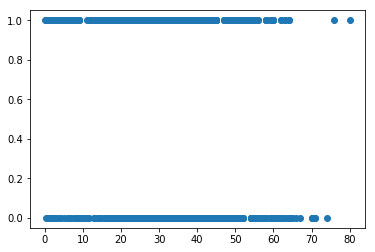

In [29]:
plt.plot(titanic.age, titanic.survived, 'o',)

## **[3] taking out only relevant features of the model and doing clean up**
note: this is not as a result of any formal feature selection, but just gut feel of what is important, and looking at the example on the intro to ML videos

link to dummies documentation: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html

In [5]:
# defining y (target)
target = titanic.survived.values

# defining X (features)
features = titanic[['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']]

In [6]:
pd.get_dummies(features).head()

,pclass,age,sibsp,parch,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
0,1,29.0000,0,0,211.3375,1,0,0,0,1
1,1,0.9167,1,2,151.5500,0,1,0,0,1
2,1,2.0000,1,2,151.5500,1,0,0,0,1
3,1,30.0000,1,2,151.5500,0,1,0,0,1
4,1,25.0000,1,2,151.5500,1,0,0,0,1


arguably, pclass is also a categorical variable. It's definitely not continuous.

In [7]:
# here we're starting the get_dummies from scratch and making explicit which categories we want
# converted into expanded boolean 

features_dummies = pd.get_dummies(features, columns=['pclass', 'sex', 'embarked'])
features_dummies.head()

,age,sibsp,parch,fare,pclass_1,pclass_2,pclass_3,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
0,29.0000,0,0,211.3375,1,0,0,1,0,0,0,1
1,0.9167,1,2,151.5500,1,0,0,0,1,0,0,1
2,2.0000,1,2,151.5500,1,0,0,1,0,0,0,1
3,30.0000,1,2,151.5500,1,0,0,0,1,0,0,1
4,25.0000,1,2,151.5500,1,0,0,1,0,0,0,1


In [21]:
# redifining X (features, with dummy variables)

data = features_dummies.values

#note: if we don't use .values, then data is a pandas df
#      if we use .values, then data is a numpyarray

# we don't have to convert with .values bc scikit learn will do it under the hood with a pdf

### **note on using numpy functions here:**

**data.isnan().any()** --> this throws the error: 'numpy.ndarray' object has no attribute 'isnan'

so what we have to do is:
**np.isnan(data).any()** because isnan takes in the numpy array as an input and then does all the computation

~ we have to deal with nan values because if we leave them in, we'll get errors in computations

### **Some documentation on Imputer **

Imputer: Looks all the values in the column, computes the mean, and replaces the missing values for the mean of that column

(A few important parameters)

**strategy :** string, optional (default=”mean”)
   - If “mean”, then replace missing values using the mean along the axis.
   - If “median”, then replace missing values using the median along the axis.
   - If “most_frequent”, then replace missing using the most frequent value along the axis.

**axis :** integer, optional (default=0)
   - If axis=0, then impute along columns.
   - If axis=1, then impute along rows.

In [20]:
np.isnan(data).any()

True

In [26]:
from sklearn.preprocessing import Imputer

# first, split the data
X_train, X_test, y_train, y_test = train_test_split(
    data, target, random_state=0)

# then clean up the NaNs
imp = Imputer()
imp.fit(X_train) # we use fit, then transform... we could have also done fit_transform

# so these are the X's we use moving forward
X_train_finite = imp.transform(X_train)
X_test_finite = imp.transform(X_test)

In [28]:
X_train_finite

array([[  0.3333    ,   0.        ,   2.        , ...,   0.        ,
          0.        ,   1.        ],
       [ 25.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   1.        ],
       [ 36.        ,   0.        ,   2.        , ...,   0.        ,
          0.        ,   1.        ],
       ..., 
       [ 30.17709646,   0.        ,   0.        , ...,   0.        ,
          1.        ,   0.        ],
       [ 20.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   1.        ],
       [ 32.        ,   1.        ,   1.        , ...,   0.        ,
          1.        ,   0.        ]])

**questions:**
- what would have happened if we left "data" as a pandas df? 
- how can we make it such that we retain the column labels in train_data_finite and are visible in .head() ?
- When we fit this in a model, how does the LogReg know which feature is which?

## **[4] Model selection **

In [29]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train_finite, y_train)
logreg_score = logreg.score(X_test_finite, y_test)

print(logreg_score)

0.792682926829


In [30]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train_finite, y_train)
knn_score = knn.score(X_test_finite, y_test)

print(knn_score)

0.689024390244


at first glance, it looks like logistic regression does better, but maybe we can improve the knn model by changing K

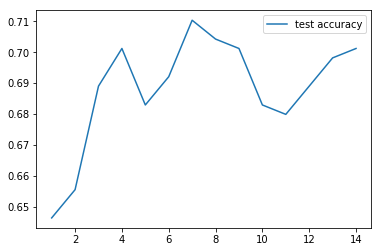

In [31]:
test_accuracy = []

neighbors_settings = range(1, 15) # try n_neighbors from 1 to 10.

for n_neighbors in neighbors_settings:

    knn = KNeighborsClassifier(n_neighbors=n_neighbors)   
    knn.fit(X_train_finite, y_train)                       # build the model

    test_accuracy.append(knn.score(X_test_finite, y_test)) # record generalization accuracy

plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.legend()

so looks like we can improve our accuracy if we switch it to 7 neigbors, but even the max is still below the Logistic Regression model

In [32]:
knn = KNeighborsClassifier(n_neighbors = 7)
knn.fit(X_train_finite, y_train)
knn_score = knn.score(X_test_finite, y_test)

print(knn_score)

0.710365853659


# Conclusion

We want to use Logistic Regression :) maybe we can get better if we do gridsearch, etc. but that's for another task.